In [20]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
#Abrimos el archivo con los nombres
dataset = open('../data/domain_names_full.txt', 'r').read().splitlines()[:10000] # Usamos solo el primer millon de dominios
dataset[:8]

['google.com',
 'a-msedge.net',
 'microsoft.com',
 'facebook.com',
 'amazonaws.com',
 'googleapis.com',
 'apple.com',
 'youtube.com']

In [22]:
charset = ['*'] + sorted(list(set([y for x in dataset for y in x])))
ctoi = {c:i for i, c in enumerate(charset)}
itoc = {i:c for i, c in enumerate(charset)}
charset_len = len(charset)
print(ctoi)

{'*': 0, '-': 1, '.': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, 'a': 13, 'b': 14, 'c': 15, 'd': 16, 'e': 17, 'f': 18, 'g': 19, 'h': 20, 'i': 21, 'j': 22, 'k': 23, 'l': 24, 'm': 25, 'n': 26, 'o': 27, 'p': 28, 'q': 29, 'r': 30, 's': 31, 't': 32, 'u': 33, 'v': 34, 'w': 35, 'x': 36, 'y': 37, 'z': 38}


In [23]:
def build_dataset(dataset: list):
    X, Y  = [], []
    for d in dataset:
        example = list(d) + ['*']
        context = [0] * context_size
        for c in example:
            X.append(context)
            Y.append(ctoi[c])
            context = context[1:] + [ctoi[c]] 
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [24]:
# build the dataset
context_size = 3
np.random.seed(42)
np.random.shuffle(dataset)
n1 = int(.8 * len(dataset))  # límite para el 80% del dataset
n2 = int(.9 * len(dataset))  # límite para el 90% del dataset
Xtr, Ytr = build_dataset(dataset[:n1])    # 80%
Xva, Yva = build_dataset(dataset[n1:n2])  # 10%
Xte, Yte = build_dataset(dataset[:n2])    # 10%

In [25]:
# MLP de nuevo...
g = torch.Generator(device='cpu').manual_seed(42)
emb_d = 10  # El número de dimensiones del Enbedding
input_size = context_size * emb_d  # el tamaño del input, desapilado
n_hidden = 128  # El número de neuronas en al capa hiddend que queremos

# Definición del modelo
C = torch.randn((charset_len, emb_d),             generator=g)
W1 = torch.randn((emb_d * context_size, n_hidden),generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, charset_len),         generator=g)
b2 = torch.randn(charset_len,                     generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

9389

In [ ]:
train_iterations = 200000
minibatch_size = 64
loss_log = []

for i in range(train_iterations):
    # training loop en mini batches
    ix = torch.randint(0, len(Xtr), (minibatch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward pass usando F.cross_entropy
    emb = C[Xb]  # embedding de los caracteres
    embcat = emb.view(-1, input_size)  # embedding como una vector de input_size
    hpreact = embcat @ W1 + b1  # pre activación de la capa oculta (h)
    h = torch.tanh(hpreact)  # activación de la capa oculta (h)
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = .1 if i < 100000 else .01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10000 == 0:
        print(f'Step: {i:7d}/{train_iterations:7d} -- loss: {loss.item():.6f}')
    loss_log.append(loss.log10().item())
print(loss.item())

In [ ]:
plt.plot(loss_log)

(array([2551.,  286.,  194.,  134.,  108.,   75.,   91.,   63.,   50.,
          55.,   60.,   51.,   43.,   43.,   46.,   32.,   48.,   36.,
          34.,   43.,   37.,   38.,   39.,   37.,   35.,   29.,   41.,
          45.,   34.,   39.,   35.,   44.,   31.,   44.,   36.,   42.,
          47.,   34.,   36.,   41.,   69.,   58.,   73.,   79.,   86.,
         100.,  132.,  159.,  318., 2311.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

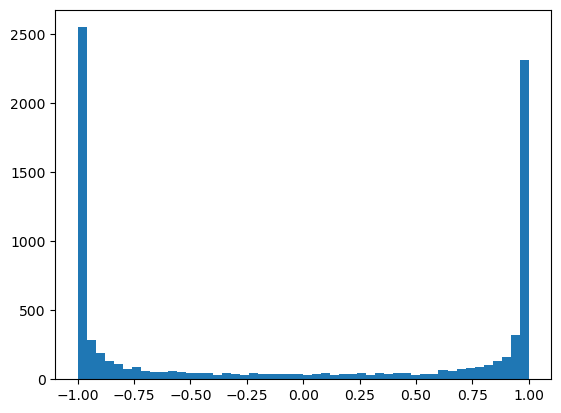

In [35]:
plt.hist(h.view(-1).tolist(),bins=50)

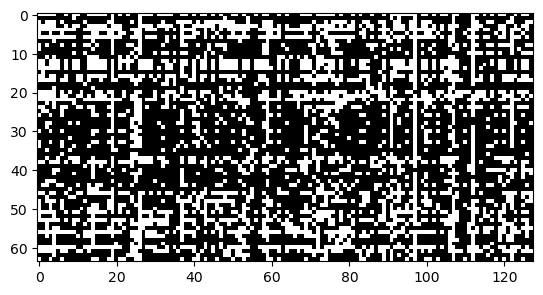

In [30]:
plt.imshow(h.abs() > 0.99, cmap='gray')

In [32]:
class Embedding():
    def __init__(self, n_embeddings, embedding_dimension):
        self.weight = torch.randn((n_embeddings, embedding_dimension))
    
    def __call__(self, x):
        self.out = self.weight[x]
        self.out = self.out.view(self.out.shape[0], -1)
        return self.out

    def parameters(self):
        return [self.weight]


class Linear():
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out))
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class Tanh():
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

## A practicar!
El siguiente código tiene algunos errores. En pricipio, el loop de training no aprende nada (el loss no baja) más allá del segundo loop. Encuentren el error.

In [33]:
context_size = 3
emb_d = 10
n_hidden = 128

model = [
    Embedding(charset_len, emb_d),
    Linear(emb_d*context_size, n_hidden), Tanh(),
    Linear(n_hidden, charset_len)
]

parameters = [p for layer in model for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True
print(f'Number of parameters: {sum((p.nelement() for p in parameters))}')

Number of parameters: 9389


In [34]:
train_iterations = 1000000
minibatch_size = 64
loss_log = []

for i in range(train_iterations):
    # training loop en mini batches
    ix = torch.randint(0, len(Xtr), (minibatch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    x = Xb
    # forward pass
    for layer in model:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in model:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data *= -lr * p.grad
    
    if i % 10000 == 0:
        print(f'Step: {i:7d}/{train_iterations:7d} -- loss: {loss.item():.6f}')
    loss_log.append(loss.log10().item())
print(loss.item())
    

Step:       0/1000000 -- loss: 23.077570
Step:   10000/1000000 -- loss: 3.663562
Step:   20000/1000000 -- loss: 3.663562
Step:   30000/1000000 -- loss: 3.663562
Step:   40000/1000000 -- loss: 3.663562


KeyboardInterrupt: 

### Haciendo inferencia
Una vez entrenado el modelo, hay que escribir una función para samplear del modelo.

In [ ]:
# Función para samplear del modelo

### Agregando capas
Nuestro modelo tiene una capa sola pero ahora agregar capas es re facil!! 

El siguiente modelo tiene varias capas. Analicen como cambiarían el training loop y la función de inferencia para que el modelo siga funcionando.

In [ ]:
model = [
    Embedding(charset_len, emb_d),
    Linear(emb_d*context_size, n_hidden), Tanh(),
    Linear(emb_d*context_size, n_hidden), Tanh(),
    Linear(emb_d*context_size, n_hidden), Tanh(),
    Linear(n_hidden, charset_len)
]

### Diagnóstico y análisis
Estaría bueno poder mostrar la saturación de la función de activación y algunos otros plots de diagnostico.

Modifiquen el modelo anterior para que tenga 7 capas ocultas. Analicen que pasa con las funciones de activación escribiendo estos plots.

In [ ]:
# Train/Validation loss plot

In [ ]:
# Saturación de las neuronas de las diferentes capas

In [ ]:
# Histograma de saturacion de las capas (a la Karpathy https://youtu.be/P6sfmUTpUmc?feature=shared&t=5242)